In [27]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3

# 0. Connect to Mongo and define a specific database

In [3]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [4]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

7.864450216293335


In [5]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


# 2. Divide the sample time period in two and compute time changes

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

In [6]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2014-06-30T00:00:00.000000000', '2013-09-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2013-03-31T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2015-03-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2013-06-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2013-12-31T00:00:00.000000000', '2014-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [39]:
df.describe()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,period
count,204800.000000,203578.000000,32190.000000,206078.000000,206078.000000
mean,25.376123,23.488859,26.291208,29.325518,0.764002
std,186.169569,178.511885,97.439338,196.890008,0.424622
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,4.000000,2.000000,1.000000
75%,9.000000,9.000000,18.000000,11.000000,1.000000
max,26034.000000,26034.000000,4526.000000,26034.000000,1.000000


In [40]:
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,period
time,,,,,
2012-09-30,229761.0,211742.0,30339.0,260100.0,0
2012-12-31,356359.0,323790.0,61568.0,417927.0,0
2013-03-31,419450.0,380960.0,70364.0,489814.0,0
2013-06-30,366380.0,331778.0,67054.0,433434.0,0
2013-09-30,387275.0,356669.0,62135.0,449410.0,14030
2013-12-31,554401.0,509939.0,89274.0,643675.0,14395
2014-03-31,469416.0,429404.0,88440.0,557856.0,14366
2014-06-30,446140.0,402041.0,84390.0,530530.0,14379
2014-09-30,332426.0,303115.0,63688.0,396114.0,14047


In [41]:
# 2 Define a midpoint date to separate the two periods in the data. 
import datetime
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30))

..\analysis.py:961: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2dif=df2.groupby('_id')['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)


Coding \ _p0 is the average level of tweets counts in the first period \ _dif is the difference between periods \ _ch stands for % changes \ _chb is an alternative % change only for those hexs with more than 50 tweets.

In [42]:
gdfchanges.head(5)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89be0819e4bffff,-0.400000,-0.400000,NaN,-0.400000,1.400000,1.400000,NaN,1.400000,-0.285714,-0.285714,NaN,-0.285714,NaN,NaN,NaN,NaN,"POLYGON ((150.63652 -33.93275, 150.63603 -33.9..."
1,89be081a053ffff,-0.333333,-0.333333,NaN,-0.333333,0.666667,0.666667,NaN,0.666667,-0.500000,-0.500000,NaN,-0.500000,NaN,NaN,NaN,NaN,"POLYGON ((150.66875 -34.06108, 150.66826 -34.0..."
2,89be081a08bffff,1.333333,1.333333,NaN,1.333333,0.333333,0.333333,NaN,0.333333,4.000000,4.000000,NaN,4.000000,NaN,NaN,NaN,NaN,"POLYGON ((150.66486 -34.07088, 150.66437 -34.0..."
3,89be081a08fffff,-0.114286,-0.114286,NaN,-0.114286,0.400000,0.400000,NaN,0.400000,-0.285714,-0.285714,NaN,-0.285714,NaN,NaN,NaN,NaN,"POLYGON ((150.66080 -34.07159, 150.66031 -34.0..."
4,89be081a0cfffff,0.100000,0.100000,NaN,0.100000,2.400000,2.400000,NaN,2.400000,0.041667,0.041667,NaN,0.041667,NaN,NaN,NaN,NaN,"POLYGON ((150.66745 -34.06435, 150.66696 -34.0..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

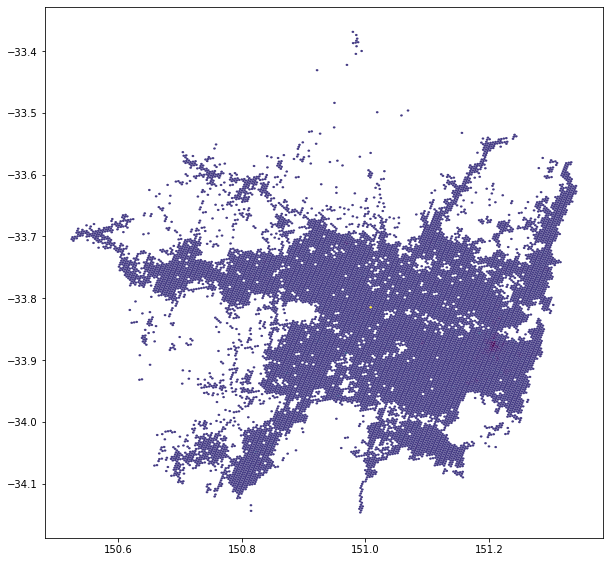

In [44]:
# Plot example
gdfchanges.plot('nonresidents_dif')
gdfchanges.crs

## 3. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [45]:
#1 Get centroids
gdfchanges_points = myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

In [47]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SA2_MAIN16          265 non-null    object  
 1   SA2_5DIG16          265 non-null    object  
 2   SA2_NAME16          265 non-null    object  
 3   SA3_CODE16          265 non-null    object  
 4   SA3_NAME16          265 non-null    object  
 5   SA4_CODE16          265 non-null    object  
 6   SA4_NAME16          265 non-null    object  
 7   GCC_CODE16          265 non-null    object  
 8   GCC_NAME16          265 non-null    object  
 9   STE_CODE16          265 non-null    object  
 10  STE_NAME16          265 non-null    object  
 11  AREASQKM16          265 non-null    float64 
 12  OID                 265 non-null    int64   
 13  SA2_MAINCODE_2016   265 non-null    int64   
 14  rentals_ov100_11    265 non-null    int64   
 15  types               265 non-null

In [48]:
tracts.AREASQKM16.sum()

3482.7441

In [49]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

tracts = gpd.read_file(shp_path/"syd.geojson")
tracts = tracts.to_crs({'init': 'epsg:4326'})

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

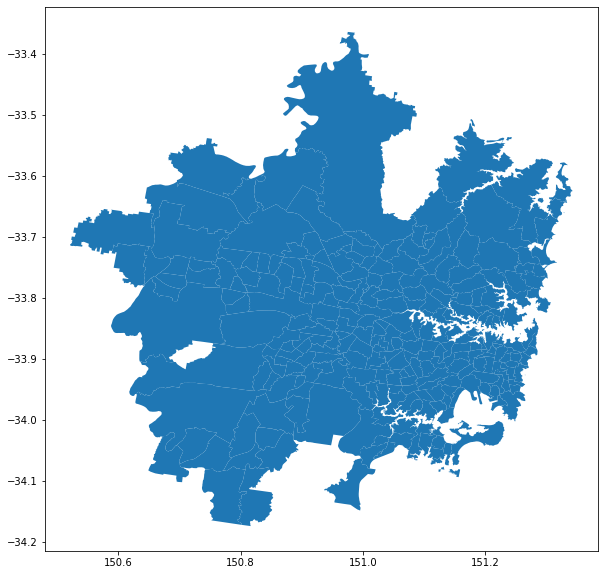

In [50]:
tracts.plot()

tracts.crs

In [51]:
# # 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [52]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,89be0819e4bffff,-0.400,-0.400,NaN,-0.400,1.400,1.400,NaN,1.400,-0.285714,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
2741,89be0852d4fffff,-0.125,-0.125,NaN,-0.125,0.250,0.250,NaN,0.250,-0.500000,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
2745,89be0852d87ffff,0.600,0.600,NaN,0.600,0.400,0.400,NaN,0.400,1.500000,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
2748,89be0852d97ffff,-0.625,-0.625,NaN,-0.625,1.125,1.125,NaN,1.125,-0.555556,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
3447,89be0856487ffff,-0.250,-0.250,NaN,-0.250,0.500,0.500,NaN,0.500,-0.500000,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"


In [53]:
typo_stats = tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem'])
#nonresidents_p0
typo_stats

nonresidents_dif                  \
                                          mean count       sem   
standardized_types                                               
Exclusive Dynamic                   -14.060833  2921  1.212268   
Exclusive Static                    -12.839180  3936  1.090817   
Low Income, At Risk of Change       -21.016144  2327  6.745199   
Low Income, Stable                   -6.934203  1576  0.928471   
Low Income, Undergoing Change       -13.267152  2250  1.101439   

                              nonresidents_ch                 nonresidents_p0  \
                                         mean count       sem            mean   
standardized_types                                                              
Exclusive Dynamic                    0.614573  2921  0.136587       28.738893   
Exclusive Static                     0.860745  3936  0.143361       26.679305   
Low Income, At Risk of Change        0.636685  2327  0.203408       54.765511   
Low Income, Stable                   1.107880  1576  0.342853       13.756443   
Low Income, Undergoing Change        0.252724  2250  0.093918       23.456593   

                                               
                              count       sem  
standardized_types                             
Exclusive Dynamic              2931  2.000481  
Exclusive Static               3950  1.432966  
Low Income, At Risk of Change  2333  5.587418  
Low Income, Stable             1585  0.793065  
Low Income, Undergoing Change  2257  1.267049

In [54]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [55]:
tweets_tracts.nonresidents_p0.describe()

count    13056.000000
mean        30.034496
std        137.826667
min          0.111111
25%          1.833333
50%          5.750000
75%         18.444444
max       6084.333333
Name: nonresidents_p0, dtype: float64

In [74]:
typo_stats = tweets_tracts[['nonresidents_dif',
                            'nonresidents_ch', 
                            'nonresidents_p0', 
                            'standardized_types']
                          ].groupby('standardized_types').agg(['median',
                                                                                      'count',
                                                                                      percentile(25), 
                                                                                      percentile(75)])
typo_stats

nonresidents_dif                      \
                                        median count percentile_25   
standardized_types                                                   
Exclusive Dynamic                    -1.444444  2921           NaN   
Exclusive Static                     -1.680556  3936           NaN   
Low Income, At Risk of Change        -4.361111  2327           NaN   
Low Income, Stable                   -1.500000  1576           NaN   
Low Income, Undergoing Change        -3.236111  2250           NaN   

                                            nonresidents_ch        \
                              percentile_75          median count   
standardized_types                                                  
Exclusive Dynamic                       NaN       -0.466667  2921   
Exclusive Static                        NaN       -0.500000  3936   
Low Income, At Risk of Change           NaN       -0.600000  2327   
Low Income, Stable                      NaN       -0.549648  1576   
Low Income, Undergoing Change           NaN       -0.600000  2250   

                                                          nonresidents_p0  \
                              percentile_25 percentile_75          median   
standardized_types                                                          
Exclusive Dynamic                       NaN           NaN        4.555556   
Exclusive Static                        NaN           NaN        5.000000   
Low Income, At Risk of Change           NaN           NaN        9.142857   
Low Income, Stable                      NaN           NaN        4.000000   
Low Income, Undergoing Change           NaN           NaN        7.333333   

                                                                 
                              count percentile_25 percentile_75  
standardized_types                                               
Exclusive Dynamic              2931           NaN           NaN  
Exclusive Static               3950           NaN           NaN  
Low Income, At Risk of Change  2333           NaN           NaN  
Low Income, Stable             1585           NaN           NaN  
Low Income, Undergoing Change  2257           NaN           NaN

In [57]:
tweets_tracts.nonresidents_ch.describe()

count    13010.000000
mean         0.690182
std          8.935343
min         -0.998938
25%         -0.782258
50%         -0.533333
75%          0.102041
max        374.000000
Name: nonresidents_ch, dtype: float64

In [25]:
tweets_tracts.nonresidents_dif.describe()

count    12963.000000
mean        -3.923493
std         99.666968
min      -1294.875000
25%         -4.071429
50%         -0.300000
75%          2.330128
max       8975.928571
Name: nonresidents_dif, dtype: float64

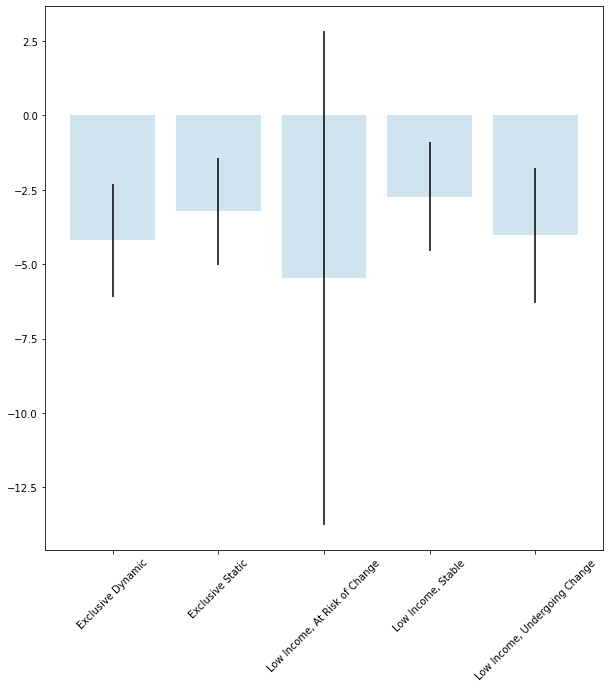

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(typo_stats.index, typo_stats['nonresidents_dif','mean'], yerr=1.96*typo_stats['nonresidents_dif','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [22]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

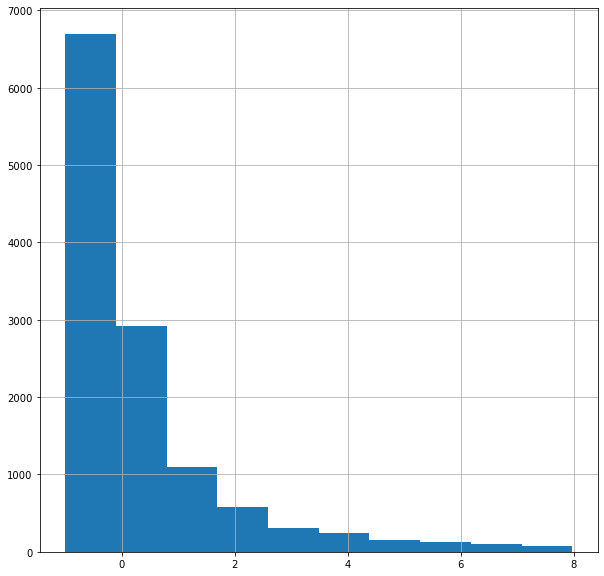

In [23]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

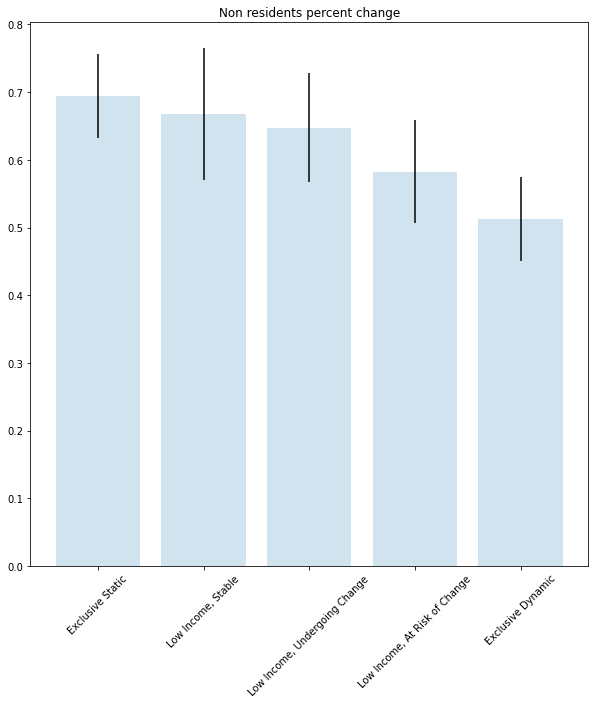

In [24]:
barchart(tweets_tracts, 'nonresidents_ch', title="Non residents percent change")

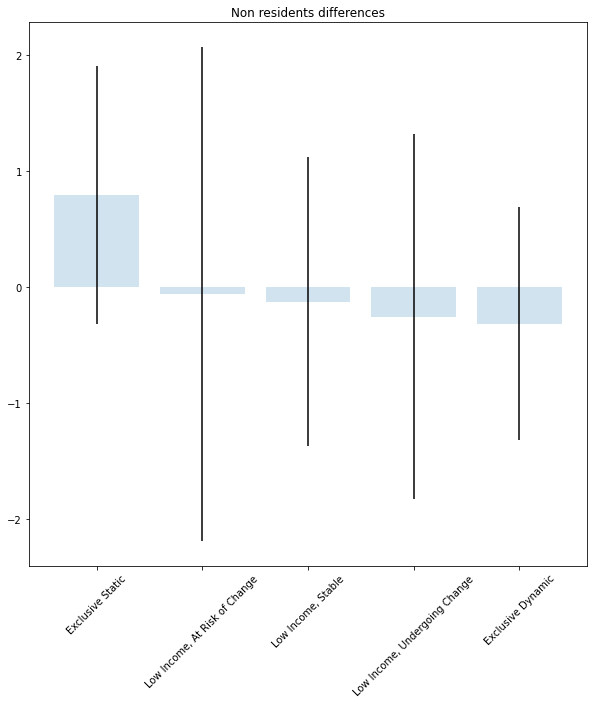

In [25]:
barchart(tweets_tracts, 'nonresidents_dif', title="Non residents differences")